In [127]:
# background comparison plotter

import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.table import Table
from datetime import datetime
import astropy.time as at
from pyspi.utils.function_utils import find_response_version
from pyspi.utils.response.spi_response_data import ResponseDataRMF
from pyspi.utils.response.spi_response import ResponseRMFGenerator
from pyspi.utils.response.spi_drm import SPIDRM
from pyspi.utils.livedets import get_live_dets
import os
from MultinestClusterFit import powerlaw_binned_spectrum
from astromodels import Powerlaw,  PointSource, SpectralComponent

data_path = "crab_data/0374"
data_path_smf = "crab_data/0374_spimodfit_bkg"
data_path_smf_bkg = "crab_data/0374_spimodfit_bkg/bg-e0020-0600"


# real data
pointing_index = 1

with fits.open(f"{data_path}/pointing.fits") as file:
    t = Table.read(file[1])
    
    pointings = np.array(t["PTID_SPI"])
    
    time_start = np.array(t["TSTART"]) + 2451544.5
    time_start = [at.Time(f"{i}", format="jd").datetime for i in time_start]
    time_start = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start])
    
print(pointings[pointing_index])
    
with fits.open(f"{data_path}/energy_boundaries.fits") as file:
    t = Table.read(file[1])
    energy_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
    
with fits.open(f"{data_path}/evts_det_spec_orig.fits") as file:
    t = Table.read(file[1])
    counts = t["COUNTS"]
    
with fits.open(f"{data_path}/dead_time.fits") as file:
    t = Table.read(file[1])
    time_elapsed = np.array(t["LIVETIME"])

time = time_start[pointing_index]
version = find_response_version(time)
rsp_base = ResponseDataRMF.from_version(version)
dets = get_live_dets(time=time, event_types=["single"])

print(dets)

indices = [pointing_index*85 + i for i in dets]
background_counts = counts[indices]
background_counts_max = np.amax(background_counts, axis=0)
background_counts_min = np.amin(background_counts, axis=0)
background_counts_mean = np.average(background_counts, axis=0)



ra, dec = 10, -40
K, piv, index = 0.0045, 40, -2
    
pl = Powerlaw()
pl.piv = piv
pl.K = K
pl.index = index
component1 = SpectralComponent("pl", shape=pl)
source = PointSource("Test", ra=ra, dec=dec, components=[component1])

emod = np.geomspace(10, 3000, 50)
spec = source(emod)
spec_binned = powerlaw_binned_spectrum(emod, spec)

rmfs = []
for d in dets:
    rmfs.append(ResponseRMFGenerator.from_time(time, d, energy_bins, emod, rsp_base))

sds = np.empty(0)
for d in range(len(dets)):
    sd = SPIDRM(rmfs[d], ra, dec)
    sds = np.append(sds, sd.matrix.T)
resp_mat = sds.reshape((len(dets), len(emod)-1, len(energy_bins)-1))

count_rates = np.dot(spec_binned, resp_mat)

source_counts = np.zeros((len(dets), len(energy_bins)-1))
for d_i, d in enumerate(dets):
    index = pointing_index * 85 + d
    source_counts[d_i,:] = np.random.poisson(count_rates[d_i,:] * time_elapsed[index])

source_counts_max = np.amax(source_counts, axis=0)
source_counts_min = np.amin(source_counts, axis=0)
source_counts_mean = np.average(source_counts, axis=0)



# smf data
with fits.open(f"{data_path_smf}/pointing.fits") as file:
    t = Table.read(file[1])
    
    pointings_smf = np.array(t["PTID_SPI"])
    
    time_start_smf = np.array(t["TSTART"]) + 2451544.5
    time_start_smf = [at.Time(f"{i}", format="jd").datetime for i in time_start_smf]
    time_start_smf = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start_smf])
    
print(pointings_smf[pointing_index])
    
with fits.open(f"{data_path_smf}/energy_boundaries.fits") as file:
    t = Table.read(file[1])
    energy_bins_smf = np.append(t["E_MIN"], t["E_MAX"][-1])
    
    
with fits.open(f"{data_path_smf}/dead_time.fits") as file:
    t = Table.read(file[1])
    time_elapsed_smf = np.array(t["LIVETIME"])
    
e_indices = []
for e in energy_bins_smf:
    temp = np.argwhere(energy_bins==e)
    if len(temp)>0:
        e_indices.append(temp[0][0])
        
# print(energy_bins_smf)

binned_background_counts = np.empty((len(dets), len(e_indices)-1))
for i in range(len(e_indices)-1):
    binned_background_counts[:,i] = np.sum(background_counts[ : , e_indices[i] : e_indices[i+1]], axis=1)
    
binned_background_counts_max = np.amax(binned_background_counts, axis=0)
binned_background_counts_min = np.amin(binned_background_counts, axis=0)
binned_background_counts_mean = np.average(binned_background_counts, axis=0)

with fits.open(f"{data_path_smf_bkg}/output_bgmodel-conti.fits.gz") as file:
    t = Table.read(file[1])
    conti = t["COUNTS"]
with fits.open(f"{data_path_smf_bkg}/output_bgmodel-lines.fits.gz") as file:
    t = Table.read(file[1])
    lines = t["COUNTS"]



smf_indices = [19*pointing_index + i for i in dets]

# print(lines[smf_indices])
# print(conti[smf_indices])
# print(binned_background_counts)
# print(time_elapsed[smf_indices])

smf_background_counts = (np.random.poisson(np.abs(lines[smf_indices])) * np.sign(lines[smf_indices])
                        + np.random.poisson(np.abs(conti[smf_indices])) * np.sign(conti[smf_indices]))
smf_background_counts_max = np.amax(smf_background_counts, axis=0)
smf_background_counts_min = np.amin(smf_background_counts, axis=0)
smf_background_counts_mean = np.average(smf_background_counts, axis=0)

fig, ax = plt.subplots(nrows=2, figsize=(8,8))

ax[0].step(energy_bins[:-1], background_counts_mean, color="r", where="post", label="Real Background")
ax[0].fill_between(energy_bins[:-1], background_counts_min, background_counts_max, step="post", color="r", alpha=0.3)
# plt.step(energy_bins[:-1], background_counts_min, color="r", lw=0.1, alpha=0.3)
# plt.step(energy_bins[:-1], background_counts_max, color="r", lw=0.1, alpha=0.3)

ax[0].step(energy_bins[:-1], source_counts_mean, color="g", where="post", label="Simulated Crab-like Source")
ax[0].fill_between(energy_bins[:-1], source_counts_min, source_counts_max, step="post", color="g", alpha=0.3)

ax[0].set_yscale("symlog")
ax[1].set_yscale("log")

plt.xlabel("Energy [keV]")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Counts")



ax[1].step(energy_bins_smf[:-1], binned_background_counts_mean, color="r", where="post", label="Real Background")
ax[1].step(energy_bins_smf[-2:], np.repeat(binned_background_counts_mean[-1], 2), color="r", where="post")
ax[1].fill_between(energy_bins_smf[:-1], binned_background_counts_min, binned_background_counts_max, step="post", color="r", alpha=0.3)
ax[1].fill_between(energy_bins_smf[-2:], 
                   np.repeat(binned_background_counts_min[-1], 2), 
                   np.repeat(binned_background_counts_max[-1], 2), 
                   step="post", color="r", alpha=0.3)

ax[1].step(energy_bins_smf[:-1], smf_background_counts_mean, color="b", where="post", label="Spimodfit Background")
ax[1].step(energy_bins_smf[-2:], np.repeat(smf_background_counts_mean[-1], 2), color="b", where="post")
ax[1].fill_between(energy_bins_smf[:-1], smf_background_counts_min, smf_background_counts_max, step="post", color="b", alpha=0.3)
ax[1].fill_between(energy_bins_smf[-2:], 
                   np.repeat(smf_background_counts_min[-1], 2), 
                   np.repeat(smf_background_counts_max[-1], 2), 
                   step="post", color="b", alpha=0.3)

ax[0].legend()
ax[1].legend()


path_d = "simulated_data/background_analysis"
if not os.path.exists(f"{path_d}"):
    os.mkdir(f"{path_d}")
    
plt.savefig(f"{path_d}/background.pdf")



03740002.000000
Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18]
03740002.000000


[  1.33014098   1.45027079   1.0586005    0.95725694   1.25922675
   0.88795138   1.05997008   1.11220851   1.00875831   1.63910959
   1.61885319   1.07504558   1.42768081   1.3331456    0.9497833
   1.46144557   1.00455007   1.16309166   0.93907607 481.76590284]
[  1.08139215   1.16001516   1.12221583   1.10503273   1.17145369
   1.02941066   1.0384269    0.96492502   1.25664963   1.1703684
   1.16434809   0.85667813   1.13659755   1.28645036   0.896282
   1.44350601   1.11910681   0.91748643   0.90025465 242.65428288]


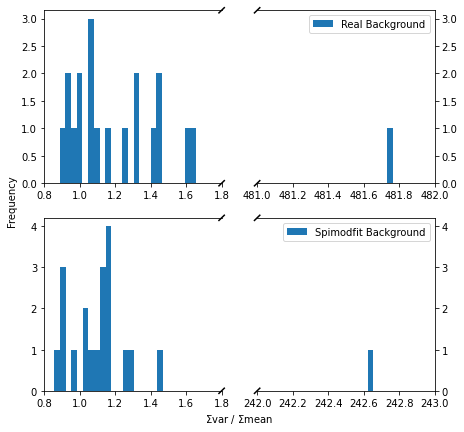

In [62]:
# background spread comparison

import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.table import Table
from datetime import datetime
import astropy.time as at
from pyspi.utils.function_utils import find_response_version
# from pyspi.utils.response.spi_response_data import ResponseDataRMF
# from pyspi.utils.response.spi_response import ResponseRMFGenerator
# from pyspi.utils.response.spi_drm import SPIDRM
from pyspi.utils.livedets import get_live_dets
import os
import pickle
# from MultinestClusterFit import powerlaw_binned_spectrum
# from astromodels import Powerlaw,  PointSource, SpectralComponent

np.random.seed(0)

path_c = "sim_source_0374_w_smf_bkg"
path_r = "crab_data/0374"
path_smf = "crab_data/0374_spimodfit_bkg"
path_smf_p = "crab_data/0374_spimodfit"

with open(f"./{path_c}/pointings.pickle", "rb") as f:
    d = pickle.load(f)
    

with fits.open(f"{path_r}/pointing.fits") as file:
    t = Table.read(file[1])
    
    pointings = np.array(t["PTID_SPI"])
    
    time_start = np.array(t["TSTART"]) + 2451544.5
    time_start = [at.Time(f"{i}", format="jd").datetime for i in time_start]
    time_start = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start])

assert find_response_version(time_start[0]) == find_response_version(time_start[-1]), "Versions not constant"
version = find_response_version(time_start[0])
dets = get_live_dets(time=time_start[0], event_types=["single"])

r_indices = []
for c_i, cluster in enumerate(d):
    t = []
    for p_i, pointing in enumerate(cluster):
        for p_i2, pointing2 in enumerate(pointings):
            if pointing[0][:8] == pointing2[:8]:
                t.append(p_i2)
                break
    r_indices.append(t)
    
r_indices = np.array(r_indices)
    
with fits.open(f"{path_smf_p}/pointing.fits.gz") as file:
    t = Table.read(file[1])
    
    pointings_smf = np.array(t["PTID_SPI"])

smf_indices = []
for c_i, cluster in enumerate(d):
    t = []
    for p_i, pointing in enumerate(cluster):
        for p_i2, pointing2 in enumerate(pointings_smf):
            if pointing[0][:8] == pointing2[:8]:
                t.append(p_i2)
                break
    smf_indices.append(t)
    
smf_indices = np.array(smf_indices)

with fits.open(f"{path_r}/energy_boundaries.fits") as file:
    t = Table.read(file[1])
    r_e_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
    
with fits.open(f"{path_smf}/energy_boundaries.fits") as file:
    t = Table.read(file[1])
    smf_e_bins = np.append(t["E_MIN"], t["E_MAX"][-1])

e_indices = []
for e in smf_e_bins:
    temp = np.argwhere(r_e_bins==e)
    if len(temp)>0:
        e_indices.append(temp[0][0])


with fits.open(f"{path_r}/evts_det_spec_orig.fits") as file:
    t = Table.read(file[1])
    r_counts = t["COUNTS"]
    
r_counts_binned = np.zeros((len(r_counts), len(smf_e_bins)-1))
for i in range(len(e_indices)-1):
    r_counts_binned[:,i] = np.sum(r_counts[ : , e_indices[i] : e_indices[i+1]], axis=1)

r_var = []
r_mean = []
r_n = 0

for combination in r_indices:
    indices1 = [85*combination[0] + i for i in dets]
    indices2 = [85*combination[1] + i for i in dets]
    
    counts1 = r_counts_binned[indices1]
    counts2 = r_counts_binned[indices2]
    
    mean = (counts1 + counts2) / 2
    variance = (counts1 - mean)**2 + (counts2 - mean)**2
    size = np.size(counts1)
    
    r_mean.append(np.sum(mean))
    r_var.append(np.sum(variance))
    r_n += size
    
r_var = np.array(r_var)
r_mean = np.array(r_mean)
r_ratio = r_var/r_mean


with fits.open(f"{path_smf}/bg-e0020-0600/output_bgmodel-conti.fits.gz") as file:
    t = Table.read(file[1])
    conti = t["COUNTS"]
with fits.open(f"{path_smf}/bg-e0020-0600/output_bgmodel-lines.fits.gz") as file:
    t = Table.read(file[1])
    lines = t["COUNTS"]


smf_var = []
smf_mean = []
smf_n = 0


for combination in smf_indices:
    indices1 = [19*combination[0] + i for i in dets]
    indices2 = [19*combination[1] + i for i in dets]
    
    counts1 = (np.random.poisson(np.abs(lines[indices1])) * np.sign(lines[indices1])
                + np.random.poisson(np.abs(conti[indices1])) * np.sign(conti[indices1]))
    counts2 = (np.random.poisson(np.abs(lines[indices2])) * np.sign(lines[indices2])
                + np.random.poisson(np.abs(conti[indices2])) * np.sign(conti[indices2]))
    
    mean = (counts1 + counts2) / 2
    variance = (counts1 - mean)**2 + (counts2 - mean)**2
    size = np.size(counts1)
    
    smf_mean.append(np.sum(mean))
    smf_var.append(np.sum(variance))
    smf_n += size
    
smf_var = np.array(smf_var)
smf_mean = np.array(smf_mean)
smf_ratio = smf_var/smf_mean

print(r_ratio)
print(smf_ratio)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7,7))

xs = np.linspace(np.amin(r_ratio), np.amax(r_ratio), 15000)
ax[0,0].hist(r_ratio, bins=xs)
ax[0,1].hist(r_ratio, bins=xs, label="Real Background")
ax[0,0].set_xlim(0.8,1.8)
ax[0,1].set_xlim(481, 482)

ax[0,0].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,0].yaxis.tick_left()
# ax[0,0].tick_params(labelright='off')
ax[0,1].yaxis.tick_right()
# ax[0,1].tick_params(labelleft='off')

d = .015
kwargs = dict(transform=ax[0,0].transAxes, color='k', clip_on=False)
ax[0,0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0,0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax[0,1].transAxes)
ax[0,1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[0,1].plot((-d, +d), (-d, +d), **kwargs)

xs = np.linspace(np.amin(smf_ratio), np.amax(smf_ratio), 7500)
ax[1,0].hist(smf_ratio, bins=xs)
ax[1,1].hist(smf_ratio, bins=xs, label="Spimodfit Background")
ax[1,0].set_xlim(0.8,1.8)
ax[1,1].set_xlim(242, 243)

ax[0,1].legend()
ax[1,1].legend()

ax[1,0].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,0].yaxis.tick_left()
# ax[0,0].tick_params(labelright='off')
ax[1,1].yaxis.tick_right()
# ax[0,1].tick_params(labelleft='off')

d = .015
kwargs = dict(transform=ax[1,0].transAxes, color='k', clip_on=False)
ax[1,0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[1,0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax[1,1].transAxes)
ax[1,1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1,1].plot((-d, +d), (-d, +d), **kwargs)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("$\Sigma$var / $\Sigma$mean")
plt.ylabel("Frequency")

path_d = "simulated_data/background_analysis"
if not os.path.exists(f"{path_d}"):
    os.mkdir(f"{path_d}")
    
plt.savefig(f"{path_d}/background_variance.pdf")


In [6]:
# extract result matrix from simulated source

import numpy as np
import pickle

data_path = "simulated_data/0374_const_bkg_number_of_e_bins"

with open(f"./{data_path}/source_params.pickle", "rb") as f:
    a = pickle.load(f)
print(a)

def mahalanobis_dist(vals, cov, real_vals):
    dif = (vals - real_vals)
    return np.sqrt(np.linalg.multi_dot([dif, np.linalg.inv(cov), dif]))

# with open(f"./{data_path}/1_0/crab_parameters.pickle", "rb") as f:
#     d = pickle.load(f)

param1 = a[5]
# param2 = a[6]

with open(f"{data_path}/results.txt", "w") as file:
    for i in range(len(param1)):
        # for j in range(len(param2)):
            # t_path = f"{data_path}/{i}_{j}"
            t_path = f"{data_path}/{i}"
            with open(f"./{t_path}/crab_parameters.pickle", "rb") as f:
                d = pickle.load(f)
                
            
            vals, cov = d
            # real_vals = np.array([param1[i],param2[j]])
            real_vals = np.array([a[3], a[4]])
            m_d = mahalanobis_dist(vals, cov, real_vals)
            
            file.write(f"{i} : {real_vals[0]:.3e} {real_vals[1]:.3e} : {vals[0]:.3e} {vals[1]:.3e} : {m_d:.3e}\n")
            # file.write(f"{i} {j} : {real_vals[0]:.3e} {real_vals[1]:.3e} : {vals[0]:.3e} {vals[1]:.3e} : {m_d:.3e}\n")
        # file.write("\n")


(10, -40, 200.0, 0.0001, -2, [5, 25, 125, 600])


In [41]:
with open("test.txt", "w") as f:
    f.write(":")

In [5]:
# convert scw.list into pointing array

import numpy as np
import astropy.io.fits as fits
from astropy.table import Table
import astropy.time as at
from datetime import datetime
from PointingClusters import save_clusters
from IntegralPointingClustering import ClusteredQuery


with open("scw.list","r") as scw_file:
    scws = []
    with fits.open("crab_data/1667/pointing.fits") as file:
        tab = Table.read(file[1])
        for line in scw_file:
            scw = line[9:21]
            pointing_fits_info = tab[tab["PTID_ISOC"]==scw[:8]]
            t = at.Time(f'{pointing_fits_info["TSTART"][0]+2451544.5}', format='jd').iso[:-4]
            y, m, d, h, mi, s = int(t[:4]), int(t[5:7]), int(t[8:10]), int(t[11:13]), int(t[14:16]), int(t[17:19])
            tstart = datetime(y, m, d, h, mi, s)
            rax, decx= pointing_fits_info["RA_SPIX", "DEC_SPIX"].as_array()[0]
            
            scws.append(np.array([scw, rax, decx, tstart]))
            
    scws = np.array(scws)
    
cq = ClusteredQuery(
    scws,
    angle_weight=0.,
    time_weight=5.,
    max_distance=1.,
    min_ang_distance=1.5,
    max_ang_distance=7.5,
    cluster_size_range = (2,2),
    failed_improvements_max=3,
    suboptimal_cluster_size=1,
    close_suboptimal_cluster_size=1
).get_clustered_scw_ids()

pointings = []
for size in range(2, 3):
    for cluster in cq[size]:
        pointings.append(tuple([(i, f"crab_data/{i[:4]}") for i in cluster]))
pointings = tuple(pointings)

folder = "orbit_1667_spimodfit_scws"

save_clusters(pointings, folder)


In [2]:
# quartic root

import matplotlib.pyplot as plt
import math
import numpy as np

def quartic_root(A, B, C, D, E):
    alpha = -3 * B**2 / (8 * A**2) + C/A
    beta = B**3 / (8 * A**3) - B * C / (2 * A**2) + D/A
    gamma = -3 * B**4 / (256 * A**4) + C * B**2 / (16 * A**3) - B * D / (4 * A**2) + E / A
    
    if beta == 0.:
        s1 = (alpha**2 - 4*gamma)**0.5
        s2 = ((-alpha + s1) / 2)**0.5
        x = -B/(4*A) + s2
        return x
    
    P = -(alpha**2)/12 - gamma
    Q = -(alpha**3)/108 + alpha*gamma/3 - (beta**2) / 8
    R = -Q/2 + (Q**2 / 4 + P**3 / 27)**0.5
    U = R**(1/3)
    if U == 0.:
        y = -5/6*alpha - (Q**(1/3))
    else:
        y = -5/6*alpha + U - P/(3*U)
    W = (alpha + 2*y)**0.5
    
    s1 = 2*beta/W
    s2 = (-(3*alpha + 2*y + s1))**0.5
    s3 = (W + s2) / 2
    x = -B / (4*A) + s3
    return x

In [12]:
quartic_root(-20.144230141415672, -10.332401583717097, 749.272358187044, 2301.1616043142335, 1578.436366036694)

(7.145137971906084-1.6766410874710565e-18j)

In [17]:
def b_maxL_4(m, t, C):
    t_t = np.sum(t)
    C_ = np.zeros(4)
    m_plus = np.zeros(4)
    m_cross = np.zeros(4)
    m_dot = np.zeros(4)
    
    for i in range(4):
        C_[i] = C[i] - t[i] * m[i]
        m_plus[i] = m[(i+1) % 4] + m[(i+2) % 4] + m[(i+3) % 4]
        m_cross[i] = (m[(i+1) % 4] * m[(i+2) % 4]
                      + m[(i+2) % 4] * m[(i+3) % 4]
                      + m[(i+3) % 4] * m[(i+1) % 4])
        m_dot[i] = m[(i+1) % 4] * m[(i+2) % 4] * m[(i+3) % 4]
        
    A = -t_t.item()
    B = np.sum(C_ - t * m_plus).item()
    C = np.sum(C_ * m_plus - t * m_cross).item()
    D = np.sum(C_ * m_cross - t * m_dot).item()
    E = np.sum(C_ * m_dot).item()
    
    # print(A,B,C,D,E)
    
    alpha = -3 * B**2 / (8 * A**2) + C/A
    beta = B**3 / (8 * A**3) - B * C / (2 * A**2) + D/A
    gamma = -3 * B**4 / (256 * A**4) + C * B**2 / (16 * A**3) - B * D / (4 * A**2) + E / A
    
    if beta == 0.:
        s1 = (alpha**2 - 4*gamma)**0.5
        s2 = ((-alpha + s1) / 2)**0.5
        x = -B/(4*A) + s2
        return x
    
    P = -(alpha**2)/12 - gamma
    Q = -(alpha**3)/108 + alpha*gamma/3 - (beta**2) / 8
    R = -Q/2 + (Q**2 / 4 + P**3 / 27)**0.5
    U = R**(1/3)
    if U == 0.:
        y = -5/6*alpha - (Q**(1/3))
    else:
        y = -5/6*alpha + U - P/(3*U)
    W = (alpha + 2*y)**0.5
    
    s1 = 2*beta/W
    s2 = (-(3*alpha + 2*y + s1))**0.5
    s3 = (W + s2) / 2
    x = -B / (4*A) + s3
    return x.real
    

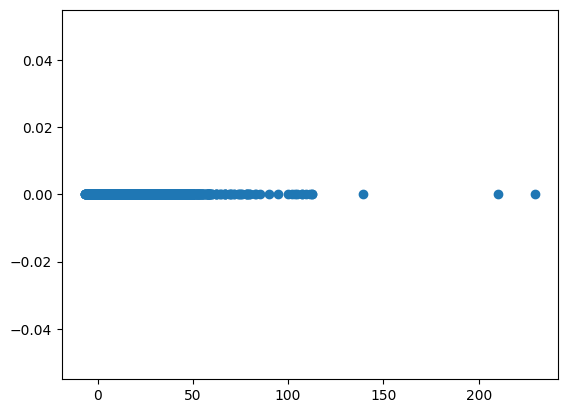

In [18]:
# b_maxl_4 tester
res = []

for i in range(100000):
    m = np.random.random(4) * 10
    t = np.random.random(4) * 10
    C = np.random.random(4) * 100
    
    res.append(b_maxL_4(m, t, C))
    
plt.scatter([i.real for i in res], [i.imag for i in res])

-0.002419432406213673 328.4167336591813 30.581394336596986 92.33436282645096 370.06679559099564 135741.32433394087 -4.97781741087249
-0.0006417204079411931 240.36756980397183 -297.6800538266573 -228.0812799130336 81.0339501403796 (374566.20063040097+8.21100664341263e-27j) (2102.0038811617123-2.7690230815135403e-13j)
-0.004201386158740661 -372.8498086483811 -144.53879866595253 -201.13093884564103 -19.86373154500967 (-0.1452607999126485+0.7000881309888265j) (-1.3491680326185254-0.00014285282406945043j)
0.008645912093015795 -438.5045411596967 -96.37837600535516 -228.02232193731908 -460.6160536213556 50718.35531022401 -3.350407662872385
0.0001258145736642291 -368.67328741445925 292.8827294132702 -109.78312368111034 135.16703983169964 2930290.003193867 3236.82488634211
33.96298316434297 69.56653122525506 -191.93309800250103 -234.2033070878755 -210.33239468290134 (1.389894873088009-0.027421174940243716j) (-593.4653616177065+6.217248937900877e-15j)
-54.82293796481099 42.51828012353826 443.623

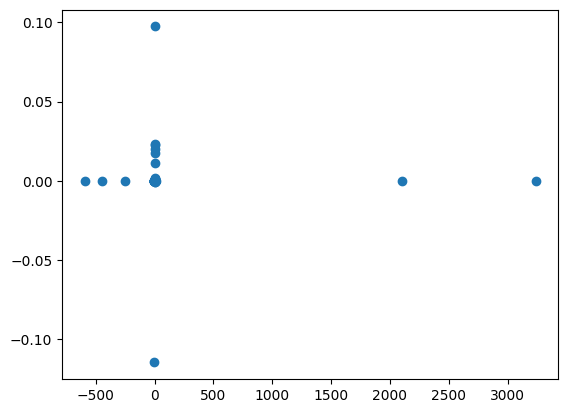

In [3]:
# quartic root tester

res = []
for i in range(1000000):
    arg = np.random.random(5)*1000-500
    A = float(arg[0])
    B = float(arg[1])
    C = float(arg[2])
    D = float(arg[3])
    E = float(arg[4])
    x = quartic_root(A, B, C, D, E)

            
    res.append(
        (A*x**4 + B*x**3 + C*x**2 + D*x + E)
    )
    if abs(res[-1]) > 1.:
        print(A, B, C, D, E, x, res[-1])
plt.scatter([i.real for i in res], [i.imag for i in res])

In [1]:
# number of scws in crab FOV per revolution

from IntegralQuery import SearchQuery, IntegralQuery, Filter, Range
from astropy.coordinates import SkyCoord

p = SkyCoord(40.664, -0.004, frame="icrs", unit="deg")
searchquerry = SearchQuery(position=p, radius="5 degree",)
cat = IntegralQuery(searchquerry)
f = Filter(SCW_TYPE="POINTING")
scw_ids_all = cat.apply_filter_on_revolutions(f)
for orbit, count in scw_ids_all.items():
    print(orbit, count)

0098 44
0099 19
0207 7
0208 10
0209 6
0336 1
0341 3
0456 1
0457 3
0570 2
0571 5
0572 3
0573 1
0695 2
0696 2
0697 3
0698 2
0700 6
0701 3
1066 2
1199 2
1200 1
1204 2
1205 1
1447 2


In [28]:
# query scw

from astroquery.heasarc import Heasarc, Conf
import astropy.units as u
from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd

integral_query = Heasarc()
Conf.server.set('https://www.isdc.unige.ch/browse/w3query.pl')
query_dict= {}
query_dict["mission"] = "integral_rev3_scw"
query_dict["position"] = SkyCoord(0, 90, frame="icrs", unit="deg")
query_dict["radius"] = "15 degree"
query_dict["sortvar"] = "START_DATE"
query_dict["resultmax"] = 0
r = integral_query.query_region(**query_dict)
r.convert_bytestring_to_unicode()
p = r.to_pandas()

mask = [False] * len(p)
for i in range(len(p)):
    if p["SCW_ID"][i][:4] == "1380":
        mask[i] = True 
        
p[mask]


,SCW_ID,SCW_VER,SCW_TYPE,RA_X,DEC_X,OBS_ID,OBS_TYPE,START_DATE,END_DATE,PI_NAME,PS,GOOD_SPI,GOOD_PICSIT,GOOD_ISGRI,GOOD_JEMX,GOOD_JEMX1,GOOD_JEMX2,GOOD_OMC,DSIZE,SEARCH_OFFSET_
721,138000020021,001,SLEW,302.888005131429,82.8963595232088,...,,2014-01-31 06:40:26,2014-01-31 06:57:12,...,PUBLIC,890,0,0,0,0,0,329,4960256,"426.219 (114.57397520683577,89.99999392167888)\n"
722,138000030010,001,POINTING,132.584243774414,76.3796691894531,...,,2014-01-31 06:57:12,2014-01-31 07:07:04,...,PUBLIC,570,0,0,0,0,0,570,10584064,"817.220 (114.57397520683577,89.99999392167888)\n"
723,138000030021,001,SLEW,132.926624239718,76.3780198676247,...,,2014-01-31 07:07:04,2014-01-31 07:08:32,...,PUBLIC,87,7,9,0,0,0,88,2560000,"817.318 (114.57397520683577,89.99999392167888)\n"
724,138000040010,001,POINTING,133.813827514648,76.3709182739258,11700010001 ...,TOO,2014-01-31 07:08:32,2014-01-31 07:57:51,PUBLIC ...,PUBLIC,2904,13,2896,2112,2112,2111,2895,119406592,"817.745 (114.57397520683577,89.99999392167888)\n"
725,138000040021,001,SLEW,137.361134437952,76.4204226123182,11700010001 ...,TOO,2014-01-31 07:57:51,2014-01-31 08:00:16,PUBLIC ...,PUBLIC,144,136,145,145,145,145,0,6959104,"814.774 (114.57397520683577,89.99999392167888)\n"
726,138000050010,001,POINTING,143.094909667969,76.379753112793,11700010001 ...,TOO,2014-01-31 08:00:16,2014-01-31 08:48:58,PUBLIC ...,PUBLIC,2876,2861,2874,2876,2876,2876,2876,108703744,"817.214 (114.57397520683577,89.99999392167888)\n"
727,138000050021,001,SLEW,146.785530133209,76.2995518536753,11700010001 ...,TOO,2014-01-31 08:48:58,2014-01-31 08:51:22,PUBLIC ...,PUBLIC,143,136,144,143,143,143,0,6111232,"822.027 (114.57397520683577,89.99999392167888)\n"
728,138000060010,001,POINTING,152.128952026367,76.0623626708984,11700010001 ...,TOO,2014-01-31 08:51:22,2014-01-31 09:40:04,PUBLIC ...,PUBLIC,2877,2855,2875,2877,2877,2877,2877,99745792,"836.258 (114.57397520683577,89.99999392167888)\n"
729,138000060021,001,SLEW,155.981095455661,75.831078331196,11700010001 ...,TOO,2014-01-31 09:40:04,2014-01-31 09:42:02,PUBLIC ...,PUBLIC,117,112,118,117,115,117,0,5005312,"850.135 (114.57397520683577,89.99999392167888)\n"
730,138000070010,001,POINTING,160.586578369141,75.4391098022461,11700010001 ...,TOO,2014-01-31 09:42:02,2014-01-31 10:30:56,PUBLIC ...,PUBLIC,2881,2868,2879,2881,2881,2881,2881,95211520,"873.653 (114.57397520683577,89.99999392167888)\n"


In [2]:
# Spimodfit new source

from astropy.io import fits
from astropy.table import Table
with fits.open("spimodfit/cat_SPI_allsrcs.fits.gz") as f:
    t = Table.read(f[1])
d = t[[0]]

d["RA_OBJ"], d["DEC_OBJ"] = np.array([10.]), np.array([-40.])
d["NAME"] = "SimSource_0374"
hdu = fits.BinTableHDU(data=d, name="SPI.-SRCL-CAT")
hdu.writeto('spimodfit/cat_sim_0374.fits.gz')